## Using TensorFlow's Dataset API

TensorFlow provides users with multiple options for providing data to the model. One of the probably most common methods is to define placeholders in the TensorFlow graph and feed the data from the current Python session into the TensorFlow Session using the feed_dict parameter. Using this approach, a large dataset that does not fit into memory is most conveniently and efficiently stored using NumPy archives as explained in [Chunking an Image Dataset for Minibatch Training using NumPy NPZ Archives](https://render.githubusercontent.com/view/image-data-chunking-npz.ipynb) or HDF5 data base files ([Storing an Image Dataset for Minibatch Training using HDF5](https://render.githubusercontent.com/view/image-data-chunking-hdf5.ipynb)).

Another approach, which is often preferred when it comes to computational efficiency, is to do the "data loading" directly in the graph using input queues from so-called TFRecords files, which is illustrated in the [Using Input Pipelines to Read Data from TFRecords Files](https://render.githubusercontent.com/view/tfrecords.ipynb) notebook.

Now, one could also use inpute input queues to load the data directly on the graph [Using Queue Runners to Feed Images Directly from Disk](https://render.githubusercontent.com/view/file-queues.ipynb). The examples in this Jupyter notebook present an alternative to this manual approach, using TensorFlow's "new" Dataset API, which is described in more detail here: https://www.tensorflow.org/programmers_guide/datasets

### 0. The Dataset

In [1]:
import numpy as np

import sys
sys.path.insert(0, '..')
from helper import mnist_export_to_jpg

In [2]:
random_seed = 123
np.random.seed(random_seed)

mnist_path = "D:/work/data/Python/tensorflow/mnist/data/"
mnist_export_to_jpg(path=mnist_path)

D:/work/data/Python/tensorflow/mnist/data/
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:/work/data/Python/tensorflow/mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting D:/work/data/Python/tensorflow/mnist/data/train-labels-idx1-ubyte.gz
Extracting D:/work/data/Python/tensorflow/mnist/data/t10k-images-idx3-ubyte.gz
Extracting D:/work/data/Python/tensorflow/mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
55000


In [3]:
import os

for i in ('train', 'valid', 'test'):
    print('mnist_%s subdirectories' % i, os.listdir(os.path.join(mnist_path, 'mnist_%s' % i)))

mnist_train subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_valid subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
mnist_test subdirectories ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


(28, 28, 3)


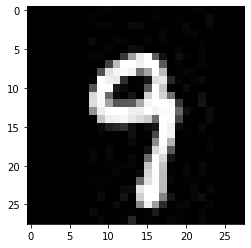

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

mnist_train_path = os.path.join(mnist_path, 'mnist_train/9/')
some_img = os.path.join(mnist_train_path, os.listdir(mnist_train_path)[0])

img = mpimg.imread(some_img)
print(img.shape)
plt.imshow(img, cmap='binary');

### 1. TensorFlow Datasets

In [30]:
import glob
import random
import re

random.seed(123)

train_paths = glob.glob(mnist_path + 'mnist_train/**/*.jpg', recursive=True)
train_labels = [int(re.split("/|\\\\", s)[-2]) for s in train_paths]
tmp = list(zip(train_paths, train_labels))
random.shuffle(tmp)
train_paths, train_labels = zip(*tmp)

valid_paths = glob.glob(mnist_path + 'mnist_valid/**/*.jpg', recursive=True)
valid_labels = [int(re.split("/|\\\\", s)[-2]) for s in valid_paths]
tmp = list(zip(valid_paths, valid_labels))
random.shuffle(tmp)
valid_paths, valid_labels = zip(*tmp)

test_paths = glob.glob(mnist_path + 'mnist_test/**/*.jpg', recursive=True)
test_labels = [int(re.split("/|\\\\", s)[-2]) for s in test_paths]
tmp = list(zip(test_paths, test_labels))
random.shuffle(tmp)
test_paths, test_labels = zip(*tmp)

In [31]:
import tensorflow as tf


data_g1 = tf.Graph()

with data_g1.as_default():
    
    # setup tensor elements for the dataset
    tf_train_paths = tf.constant(train_paths)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_paths = tf.constant(valid_paths)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_paths = tf.constant(test_paths)
    tf_test_labels = tf.constant(test_labels)
    
    
    # construct datasets from tf.Tensor objects
    train_dataset = tf.data.Dataset.from_tensor_slices((tf_train_paths,
                                                        tf_train_labels)) 
    valid_dataset = tf.data.Dataset.from_tensor_slices((tf_valid_paths,
                                                        tf_valid_labels)) 
    test_dataset = tf.data.Dataset.from_tensor_slices((tf_test_paths,
                                                       tf_test_labels)) 
    
    # initializing iterator to extract elements from the dataset
    #   Note: only need 1 iterator, since validation and test 
    #   datasets have the same image shapes
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
    
    # define op that fetches the next element from the iterator
    next_element = iterator.get_next()
    
    # define initializers for the iterator
    train_iter_init = iterator.make_initializer(train_dataset)
    valid_iter_init = iterator.make_initializer(valid_dataset)
    test_iter_init = iterator.make_initializer(test_dataset)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


In [32]:
with tf.Session(graph=data_g1) as sess:

    sess.run(train_iter_init)
    for i in range(3):
        print('Fetch element #%d from training dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)
    
    print()
    sess.run(valid_iter_init)
    for i in range(3):
        print('Fetch element #%d from validation dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)
        
    print()
    sess.run(test_iter_init)
    for i in range(3):
        print('Fetch element #%d from test dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)

Fetch element #1 from training dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_train\\5\\03475.jpg', 5)
Fetch element #2 from training dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_train\\2\\35329.jpg', 2)
Fetch element #3 from training dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_train\\8\\40264.jpg', 8)

Fetch element #1 from validation dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_valid\\0\\45967.jpg', 0)
Fetch element #2 from validation dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_valid\\6\\45182.jpg', 6)
Fetch element #3 from validation dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_valid\\7\\46306.jpg', 7)

Fetch element #1 from test dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_test\\2\\04656.jpg', 2)
Fetch element #2 from test dataset:
(b'D:/work/data/Python/tensorflow/mnist/data/mnist_test\\9\\06109.jpg', 9)
Fetch element #3 from test dataset:
(b'D:/work/data/Python/tensorflow/mnis

### 2. Preprocessing images

In [33]:
def read_image_jpg_onehot(path, label):
    str_tensor = tf.read_file(path)
    decoded_image = tf.image.decode_jpeg(str_tensor,
                                         channels=1,
                                         fancy_upscaling=False)
    # normalize to [0, 1] range
    decoded_image = tf.cast(decoded_image, tf.float32)
    decoded_image = decoded_image / 255.
    # depth=10 because we have 10 mnist class labels
    onehot_label = tf.one_hot(label, depth=10)
    return decoded_image, onehot_label

In [34]:

BATCH_SIZE = 128

def datareader():
    tf_train_paths = tf.constant(train_paths)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_paths = tf.constant(valid_paths)
    tf_valid_labels = tf.constant(valid_labels)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((tf_train_paths,
                                                        tf_train_labels)) 
    valid_dataset = tf.data.Dataset.from_tensor_slices((tf_valid_paths,
                                                        tf_valid_labels)) 
    
    ############################################################
    ## Custom data transformation; 
    #  here: image reading, shuffling, batching
    train_dataset = train_dataset.map(read_image_jpg_onehot,
                                      num_parallel_calls=4)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    
    valid_dataset = valid_dataset.map(read_image_jpg_onehot,
                                      num_parallel_calls=4)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    ############################################################

    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)

    next_element = iterator.get_next(name='next_element')
    
    train_iter_init = iterator.make_initializer(train_dataset,
                                                name='train_iter_init')
    valid_iter_init = iterator.make_initializer(valid_dataset,
                                                name='valid_iter_init')
    
    return next_element


data_g2 = tf.Graph()
with data_g2.as_default():
    datareader()

In [35]:
with tf.Session(graph=data_g2) as sess:

    sess.run('train_iter_init')
    for i in range(3):
        print('Fetch batch #%d from training dataset:' % (i+1))
        images, labels = sess.run(['next_element:0', 'next_element:1'])
        print(images.shape, labels.shape)
        
    print()
    sess.run('valid_iter_init')
    for i in range(3):
        print('Fetch batch #%d from validation dataset:' % (i+1))
        images, labels = sess.run(['next_element:0', 'next_element:1'])
        print(images.shape, labels.shape)

Fetch batch #1 from training dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #2 from training dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #3 from training dataset:
(128, 28, 28, 1) (128, 10)

Fetch batch #1 from validation dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #2 from validation dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #3 from validation dataset:
(128, 28, 28, 1) (128, 10)


### 3. Using the Dataset API to train a neural network

In [36]:
learning_rate = 0.1
n_epochs = 15
n_iter = n_epochs * (len(train_paths) // BATCH_SIZE)

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10

In [37]:
g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(123)

    # Input data
    next_element = datareader()
    
    tf_images = tf.placeholder_with_default(next_element[0],
                                            shape=[None, 28, 28, 1], 
                                            name='images')
    tf_labels = tf.placeholder_with_default(next_element[1], 
                                            shape=[None, 10], 
                                            name='labels')
    
    tf_images = tf.reshape(tf_images, (tf.shape(tf_images)[0], 784))
    tf_images = tf.cast(tf_images, dtype=tf.float32)

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([height*width, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_images, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_layer, labels=tf_labels)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    prediction = tf.argmax(out_layer, 1, name='prediction')
    correct_prediction = tf.equal(tf.argmax(tf_labels, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
with tf.Session(graph=g) as sess:
    sess.run('train_iter_init')
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            sess.run('train_iter_init')
    
    saver0.save(sess, save_path='./mlp')

Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.472
Epoch: 003 | AvgCost: 0.234
Epoch: 004 | AvgCost: 0.180
Epoch: 005 | AvgCost: 0.148
Epoch: 006 | AvgCost: 0.126
Epoch: 007 | AvgCost: 0.109
Epoch: 008 | AvgCost: 0.095
Epoch: 009 | AvgCost: 0.084
Epoch: 010 | AvgCost: 0.075
Epoch: 011 | AvgCost: 0.067
Epoch: 012 | AvgCost: 0.060
Epoch: 013 | AvgCost: 0.055
Epoch: 014 | AvgCost: 0.049
Epoch: 015 | AvgCost: 0.045


In [39]:
with tf.Session(graph=g) as sess:
    sess.run('train_iter_init')
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            sess.run('train_iter_init')
    
    saver0.save(sess, save_path='./mlp')

Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.472
Epoch: 003 | AvgCost: 0.234
Epoch: 004 | AvgCost: 0.180
Epoch: 005 | AvgCost: 0.148
Epoch: 006 | AvgCost: 0.126
Epoch: 007 | AvgCost: 0.109
Epoch: 008 | AvgCost: 0.095
Epoch: 009 | AvgCost: 0.084
Epoch: 010 | AvgCost: 0.075
Epoch: 011 | AvgCost: 0.067
Epoch: 012 | AvgCost: 0.060
Epoch: 013 | AvgCost: 0.055
Epoch: 014 | AvgCost: 0.049
Epoch: 015 | AvgCost: 0.045


### 4. Feeding new datapoints through placeholders

In [40]:
import matplotlib.image as mpimg
import numpy as np
import glob


img_paths = np.array([p for p in glob.iglob('mnist_test/*/*.jpg')])
labels = np.array([int(path.split('/')[1]) for path in img_paths])


with tf.Session() as sess:
    
    saver1 = tf.train.import_meta_graph('./mlp.meta')
    saver1.restore(sess, save_path='./mlp')
    
    num_correct = 0
    cnt = 0
    for path, lab in zip(img_paths, labels):
        cnt += 1
        image = mpimg.imread(path)
        image = image.reshape(1, 28, 28, 1)
        
        pred = sess.run('prediction:0', 
                         feed_dict={'images:0': image})

        num_correct += int(lab == pred[0])
    acc = num_correct / cnt * 100

print('Test accuracy: %.1f%%' % acc)

INFO:tensorflow:Restoring parameters from ./mlp


ZeroDivisionError: division by zero